In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_graddesc as model
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
nb_pts = [7,7]
origin1 = [[0.,0.],[10.,0.]]
radius1 = [1.,2.]
transvec = [torch.tensor([0.,2.]), torch.tensor([0.,-1])]
scal = [1.5, 0.5]

data = regdata.PointCircles(nb_pts, origin1, radius1, transvec, scal)
data.build_modules()
source = data.source
target = data.target

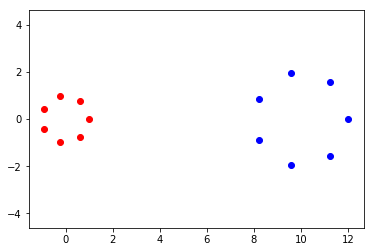

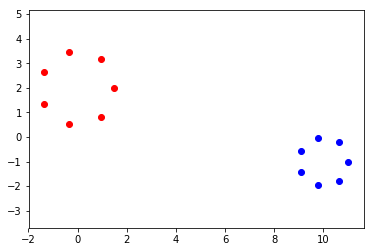

In [3]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
modules = dm.multishape.MultiShapeModule([data.modules[0], data.modules[1]])
modules.fill_controls_zero()
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [5]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id,source, target, 2, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

cost: 0.00201298819597 attach: 10.032845340790594
 iter : 0  ,total energy: 10.034858328986562
cost: 0.00201298819597 attach: 10.032845340790594
cost: 0.0780777710593 attach: 143.43815808204795
Condition 0: tensor(1, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 0  ,total energy: 143.51623585310722
cost: 0.00201298819597 attach: 10.032845340790594
cost: 0.0202820733835 attach: 67.98308835198786
Condition 0: tensor(1, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 2
 iter : 1  ,total energy: 68.00337042537134
cost: 0.00201298819597 attach: 10.032845340790594
cost: 0.00650997403813 attach: 30.771784638513545
Condition 0: tensor(1, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) ten

cost: 0.00219433231204 attach: 4.582872459823828
cost: 0.00219439212931 attach: 4.582871992636522
c 0
 iter : 37  ,total energy: 4.585066384765836
cost: 0.00219439212931 attach: 4.582871992636522
cost: 0.00219437494227 attach: 4.5828717728491615
c 0
 iter : 38  ,total energy: 4.585066147791434
cost: 0.00219437494227 attach: 4.5828717728491615
cost: 0.00219442497464 attach: 4.582871593109675
c 0
 iter : 39  ,total energy: 4.585066018084316
cost: 0.00219442497464 attach: 4.582871593109675
cost: 0.0021943834637 attach: 4.582871741228657
Condition 0: tensor(1, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(1, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 40  ,total energy: 4.585066124692355
cost: 0.00219442497464 attach: 4.582871593109675
cost: 0.00219440421751 attach: 4.5828714540108955
c 0
 iter : 41  ,total energy: 4.585065858228405
cost: 0.00219440421751 attach: 4.5828714540108955
cost

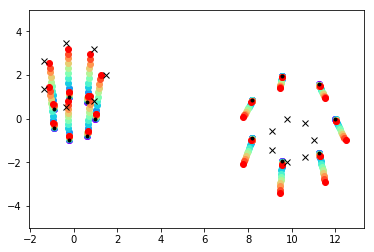

In [6]:
#%matplotlib qt5
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [7]:
# Visualization of grid deformation for each submodule
xmin, xmax = -5, 15
ymin, ymax = -5, 5
dx, dy = 0.25, 0.25

x,y, label = data.grid_label(xmin, xmax, ymin, ymax, dx, dy)
gridpoints = dm.usefulfunctions.grid2vec(x,y).type(torch.DoubleTensor)
nx, ny = x.shape


grid_silent = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(dim=2, nb_pts=len(gridpoints), gd=gridpoints.view(-1)))

EnergyFunctional.shoot_grid(grid_silent)

RuntimeError: $ Torch: not enough memory: you tried to allocate 2GB. Buy new RAM! at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/TH/THGeneral.cpp:201

In [ ]:
# Visualization of grid deformation for each submodule
xmin, xmax = -5, 15
ymin, ymax = -5, 5
dx, dy = 0.25, 0.25

x,y, label = data.grid_label(xmin, xmax, ymin, ymax, dx, dy)
gridpoints = dm.usefulfunctions.grid2vec(x,y).type(torch.DoubleTensor)
nx, ny = x.shape


grid_silent = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(dim=2, nb_pts=len(gridpoints), gd=gridpoints.view(-1)))

deformed_gridpoints = EnergyFunctional.shoot_grid(grid_silent)
 

#phi = mm.largeDeformation(modules, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(deformed_gridpoints[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(deformed_gridpoints[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(deformed_gridpoints[2], nx, ny)



plt.show()


In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), rais\gride_exception=True)

gd = gd0_tensor
mom = 1000*torch.rand(mom0_tensor.shape)


test_gradcheck_Hamiltonian()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):

        return model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param).energy_tensor(gd, mom)
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = mom0_tensor


test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_shooting():
    def shooting(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        
        intermediate_states, intermediate_controls = dm.shooting.shoot_euler(H, it=2)
        return H.module.manifold.unroll_cotan()
    return torch.autograd.gradcheck(shooting, (gd, mom), raise_exception=True,atol=1e-2)

test_gradcheck_shooting()

In [ ]:
def test_gradcheck_attachement():
    def attach(gd, mom):
        reg_param = 10**-3 

        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        energyfunc = model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param)

        return energyfunc.attach() 
    return torch.autograd.gradcheck(attach, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_attachement()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.module.compute_geodesic_variables(constr_Id)
        return H.module.controls[0]
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_autoaction():
    def autoaction(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        return mod.autoaction()
    return torch.autograd.gradcheck(autoaction, (gd, mom), raise_exception=True)

mod = data.modules[0].copy()
gd = torch.cat(mod.manifold.gd.copy())
mom = torch.cat(mod.manifold.cotan.copy())

gd.requires_grad
mom.requires_grad

test_gradcheck_autoaction()